In [1]:
import os
import sys
import csv
sys.path.insert(0, os.path.abspath('../'))

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as ax
import arrayfire as af

from dg_maxwell import params
from dg_maxwell import utils
from dg_maxwell import lagrange
from dg_maxwell import wave_equation_2d as w2d
from dg_maxwell import msh_parser
from dg_maxwell import isoparam

af.set_backend(params.backend)
af.set_device(params.device)

gmshtranslator friendly reminder: rules and actions prototypes


def node_condition(tag,x,y,z,physgroups): 
def node_action(tag,x,y,z):
def element_condition(eletag,eletype,physgrp,nodes):
def element_action(eletag,eletype,physgrp,nodes):


/home/bala/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1187: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/bala/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1214: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [2]:
nodes, elements = msh_parser.read_order_2_msh('read_and_plot_mesh/mesh/square_10_10.msh')

gmshTranslator: Initializing...
gmshTranslator: Mesh has 441 nodes.
gmshTranslator: Mesh has 144 elements.
gmshTranslator: Processed 589 lines.
gmshTranslator: There are 1 physical groups available: 
gmshTranslator:      > 0
gmshTranslator: Parsing nodes
gmshTranslator: Parsing elements
gmshTranslator: No rules for elements... skipping elements.
gmshTranslator: Parsing nodes
gmshTranslator: No rules for nodes... skipping nodes.
gmshTranslator: Parsing elements


In [3]:
def u_init(x, y):
    return np.e**(-(x**2) / 0.6**2)

gmshTranslator: Ending


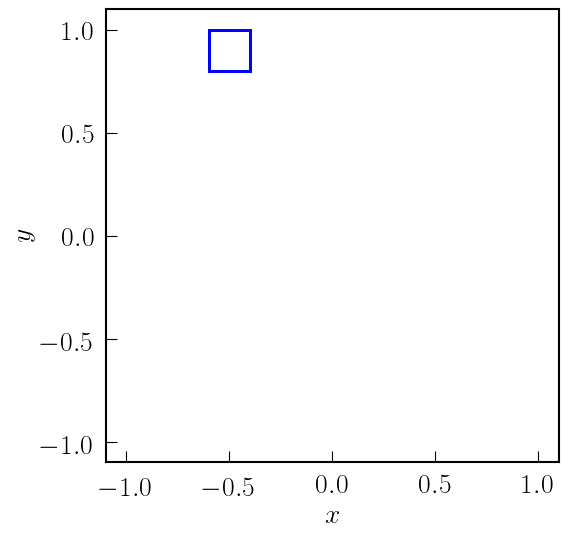

In [4]:
axes_handler = plt.axes()

# for element_id in np.arange(10, 20):
element_id = 2
msh_parser.plot_element_boundary(nodes[elements[element_id], 0],
                                 nodes[elements[element_id], 1],
                                 axes_handler)

plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.axes().set_aspect('equal')
# plt.savefig('square.png')
plt.show()


In [5]:
N_LGL      = 8
N_Elements = 10

x_e_ij  = af.np_to_af_array(np.zeros([N_LGL * N_LGL, len(elements)]))
y_e_ij  = af.np_to_af_array(np.zeros([N_LGL * N_LGL, len(elements)]))

xi_LGL  = lagrange.LGL_points(N_LGL)
eta_LGL = lagrange.LGL_points(N_LGL)

Xi_LGL, Eta_LGL = utils.af_meshgrid(xi_LGL, eta_LGL)
xi_i  = af.flat(Xi_LGL)
eta_j = af.flat(Eta_LGL)

for element_tag, element in enumerate(elements):
    x_e_ij[:, element_tag] = isoparam.isoparam_x_2D(nodes[element, 0], xi_i, eta_j)
    y_e_ij[:, element_tag] = isoparam.isoparam_y_2D(nodes[element, 1], xi_i, eta_j)


/home/bala/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1187: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/bala/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1214: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [6]:
u_e_ij = u_init(x_e_ij, y_e_ij)

In [7]:
print(u_e_ij[:,0])

arrayfire.Array()
Type: double

[64 1 1 1]
    0.0622 
    0.0622 
    0.0622 
    0.0622 
    0.0622 
    0.0622 
    0.0622 
    0.0622 
    0.0667 
    0.0667 
    0.0667 
    0.0667 
    0.0667 
    0.0667 
    0.0667 
    0.0667 
    0.0776 
    0.0776 
    0.0776 
    0.0776 
    0.0776 
    0.0776 
    0.0776 
    0.0776 
    0.0948 
    0.0948 
    0.0948 
    0.0948 
    0.0948 
    0.0948 
    0.0948 
    0.0948 
    0.1169 
    0.1169 
    0.1169 
    0.1169 
    0.1169 
    0.1169 
    0.1169 
    0.1169 
    0.1403 
    0.1403 
    0.1403 
    0.1403 
    0.1403 
    0.1403 
    0.1403 
    0.1403 
    0.1596 
    0.1596 
    0.1596 
    0.1596 
    0.1596 
    0.1596 
    0.1596 
    0.1596 
    0.1690 
    0.1690 
    0.1690 
    0.1690 
    0.1690 
    0.1690 
    0.1690 
    0.1690 




In [8]:
dxi_dx  = af.constant(0, N_LGL**2, len(elements), dtype = af.Dtype.f64)
dxi_dy  = af.constant(0, N_LGL**2, len(elements), dtype = af.Dtype.f64)
deta_dx = af.constant(0, N_LGL**2, len(elements), dtype = af.Dtype.f64)
deta_dy = af.constant(0, N_LGL**2, len(elements), dtype = af.Dtype.f64)

for element_tag, element in enumerate(elements):
    dxi_dx[:, element_tag]  = w2d.dxi_dx(nodes[element][:, 0], nodes[element][:, 1], xi_i, eta_j)
    dxi_dy[:, element_tag]  = w2d.dxi_dy(nodes[element][:, 0], nodes[element][:, 1], xi_i, eta_j)
    deta_dx[:, element_tag] = w2d.deta_dx(nodes[element][:, 0], nodes[element][:, 1], xi_i, eta_j)
    deta_dy[:, element_tag] = w2d.deta_dy(nodes[element][:, 0], nodes[element][:, 1], xi_i, eta_j)

In [9]:
def F_xi(u, dxi_dx, dxi_dy):
    '''
    '''
    F_xi_u = w2d.F_x(u) * dxi_dx + w2d.F_y(u) * dxi_dy

    return F_xi_u

def F_eta(u, deta_dx, deta_dy):
    '''
    '''
    F_eta_u = w2d.F_x(u) * deta_dx + w2d.F_y(u) * deta_dy
    
    return F_eta_u

In [10]:
def g_dd(x_nodes, y_nodes, xi, eta):
    '''
    '''
    ans00  =   (w2d.dx_dxi(x_nodes, xi, eta))**2 \
             + (w2d.dy_dxi(y_nodes, xi, eta))**2
    ans11  =   (w2d.dx_deta(x_nodes, xi, eta))**2 \
             + (w2d.dy_deta(y_nodes, xi, eta))**2
    
    ans01  =  (w2d.dx_dxi(x_nodes, xi, eta))  \
            * (w2d.dx_deta(x_nodes, xi, eta)) \
            + (w2d.dy_dxi(y_nodes, xi, eta))  \
            * (w2d.dy_deta(y_nodes, xi, eta))
    
    ans =  [[ans00, ans01],
            [ans01, ans11]
           ]
    
    return ans


def g_uu(x_nodes, y_nodes, xi, eta):
    gCov = g_dd(x_nodes, y_nodes, xi, eta)
    
    
    a = gCov[0][0]
    b = gCov[0][1]
    c = gCov[1][0]
    d = gCov[1][1]
    
    det = (a*d - b*c)
    
    ans = [[d / det, -b / det],
           [-c / det, a / det]]
    
    return ans

In [11]:
G_ab = [[af.constant(0, N_LGL * N_LGL, len(elements), dtype = af.Dtype.f64),
         af.constant(0, N_LGL * N_LGL, len(elements), dtype = af.Dtype.f64)],
        [af.constant(0, N_LGL * N_LGL, len(elements), dtype = af.Dtype.f64),
         af.constant(0, N_LGL * N_LGL, len(elements), dtype = af.Dtype.f64)]]

for element_tag, element in enumerate(elements):
    g_ab = g_uu(nodes[element][:, 0], nodes[element][:, 1], xi_i, eta_j)
    G_ab[0][0][:, element_tag] = g_ab[0][0]
    G_ab[0][1][:, element_tag] = g_ab[0][1]
    G_ab[1][0][:, element_tag] = g_ab[1][0]
    G_ab[1][1][:, element_tag] = g_ab[1][1]

In [12]:
f_xi  = F_xi(u_e_ij, dxi_dx, deta_dy)
f_eta = F_eta(u_e_ij, deta_dx, deta_dy)

In [13]:
def lax_friedrichs_flux(u):
    '''
    '''
    params.N_LGL = 8
    u = af.reorder(af.moddims(u, params.N_LGL ** 2, N_Elements, N_Elements), 2, 1, 0)

    diff_u_boundary = af.np_to_af_array(np.zeros([N_Elements, N_Elements, params.N_LGL ** 2]))

    u_xi_minus1_boundary_right   = u[:, :, :params.N_LGL]
    u_xi_minus1_boundary_left    = af.shift(u[:, :, -params.N_LGL:], d0=0, d1 = 1)
    u[:, :, :params.N_LGL] = (u_xi_minus1_boundary_right + u_xi_minus1_boundary_left) / 2
    
    diff_u_boundary[:, :, :params.N_LGL] = (u_xi_minus1_boundary_right - u_xi_minus1_boundary_left)

    u_xi_1_boundary_left  = u[:, :, -params.N_LGL:]
    u_xi_1_boundary_right = af.shift(u[:, :, :params.N_LGL], d0=0, d1=-1)
    u[:, :, :params.N_LGL]     = (u_xi_minus1_boundary_left + u_xi_minus1_boundary_right) / 2
    
    diff_u_boundary[:, :, -params.N_LGL:] = (u_xi_minus1_boundary_left - u_xi_minus1_boundary_right)

    u_eta_1_boundary_down = u[:, :, params.N_LGL - 1:params.N_LGL ** 2:params.N_LGL]
    u_eta_1_boundary_up   = af.shift(u[:, :, 0:-params.N_LGL + 1:params.N_LGL], d0=1)
    
    u[:, :, params.N_LGL - 1:params.N_LGL ** 2:params.N_LGL] = (u_eta_1_boundary_up\
                                                              +u_eta_1_boundary_down) / 2

    diff_u_boundary[:, :, params.N_LGL - 1:params.N_LGL ** 2:params.N_LGL] = (u_eta_1_boundary_up\
                                                                             -u_eta_1_boundary_down)


    u_eta_minus1_boundary_down = af.shift(u[:, :, params.N_LGL - 1:params.N_LGL ** 2:params.N_LGL], d0=-1)
    u_eta_minus1_boundary_up   = u[:, :, 0:-params.N_LGL + 1:params.N_LGL]
    u[:, :, 0:-params.N_LGL + 1:params.N_LGL] = (u_eta_minus1_boundary_down\
                                               + u_eta_minus1_boundary_up) / 2

    diff_u_boundary[:, :, 0:-params.N_LGL + 1:params.N_LGL] = (u_eta_minus1_boundary_down\
                                                             - u_eta_minus1_boundary_up)


    u = af.moddims(af.reorder(u, 2, 1, 0), params.N_LGL ** 2, N_Elements ** 2)
    diff_u_boundary = af.moddims(af.reorder(diff_u_boundary, 2, 1, 0), params.N_LGL ** 2, N_Elements ** 2)
    F_xi_e_ij  = F_xi(u, dxi_dx, deta_dy) - params.c_lax * diff_u_boundary
    F_eta_e_ij = F_eta(u, deta_dx, deta_dy) - params.c_lax * diff_u_boundary

    return F_xi_e_ij, F_eta_e_ij

In [14]:
print(af.max(af.abs(lax_friedrichs_flux(u_e_ij)[1][:, :] - f_eta[:, :])))

5.042521955545012e-12


In [15]:
print(G_ab[0][0].shape)

(64, 100)


In [16]:
print(f_xi.shape)

(64, 100)


In [17]:
lagrange_coeffs = af.np_to_af_array(lagrange.lagrange_polynomials(xi_LGL)[1])

In [18]:
print(lagrange_coeffs)

arrayfire.Array()
Type: double

[8 8 1 1]
   -3.3516     3.3516     3.8672    -3.8672    -1.0547     1.0547     0.0391    -0.0391 
    8.1407    -7.0966   -11.3475     9.8921     3.3316    -2.9043    -0.1249     0.1088 
  -10.3581     6.1289    18.6834   -11.0549    -8.6700     5.1301     0.3448    -0.2040 
   11.3898    -2.3839   -24.0330     5.0301    15.6735    -3.2805    -3.0304     0.6343 
  -11.3898    -2.3839    24.0330     5.0301   -15.6735    -3.2805     3.0304     0.6343 
   10.3581     6.1289   -18.6834   -11.0549     8.6700     5.1301    -0.3448    -0.2040 
   -8.1407    -7.0966    11.3475     9.8921    -3.3316    -2.9043     0.1249     0.1088 
    3.3516     3.3516    -3.8672    -3.8672     1.0547     1.0547    -0.0391    -0.0391 




In [86]:
def surface_term(u):
    '''
    '''
    error = af.np_to_af_array(np.zeros([params.N_LGL ** 2]))
    for p in range(params.N_LGL):
        for q in range(params.N_LGL):

            f_xi_surface_term  = lax_friedrichs_flux(u)[0]
            f_eta_surface_term = lax_friedrichs_flux(u)[1]

            Lp_coeffs = lagrange_coeffs[p]
            Lq_coeffs = lagrange_coeffs[q]
            Lq_eta    = af.transpose(utils.polyval_1d(Lq_coeffs, eta_LGL))
            Lp_xi     = af.transpose(utils.polyval_1d(Lp_coeffs, xi_LGL))
            Lp_1      = utils.polyval_1d(lagrange_coeffs[p], xi_LGL[-1])
            Lq_1      = utils.polyval_1d(lagrange_coeffs[q], eta_LGL[-1])
            Lp_minus1 = utils.polyval_1d(lagrange_coeffs[p], xi_LGL[0])
            Lq_minus1 = utils.polyval_1d(lagrange_coeffs[q], eta_LGL[0])

            # xi = 1 boundary
            Lq_eta_F = af.broadcast(utils.multiply, \
                                    Lq_eta, G_ab[0][0][-params.N_LGL:, :] * f_xi_surface_term[-params.N_LGL:, :]\
                                           + G_ab[1][0][-params.N_LGL:, :] * f_eta_surface_term[-params.N_LGL:, :])
            Lq_eta_F = af.reorder(Lq_eta_F, 0, 2, 1)

            lag_interpolation_1 = af.reorder(\
                                             af.sum(af.broadcast(utils.multiply, lagrange_coeffs, Lq_eta_F), 0),\
                                             2, 1, 0)

            surface_term_pq_xi_1 = af.sum(Lp_1) * lagrange.integrate(lag_interpolation_1)

            # eta = 1 boundary
            Lp_xi_F = af.broadcast(utils.multiply,\
                                  Lp_xi, G_ab[1][0][params.N_LGL - 1:params.N_LGL ** 2:params.N_LGL]\
                                       * f_xi_surface_term[params.N_LGL - 1:params.N_LGL ** 2:params.N_LGL]\
                                       + G_ab[1][1][params.N_LGL - 1:params.N_LGL ** 2:params.N_LGL]\
                                       * f_eta_surface_term[params.N_LGL - 1:params.N_LGL ** 2:params.N_LGL])
            Lp_xi_F = af.reorder(Lp_xi_F, 0, 2, 1)

            lag_interpolation_2 = af.reorder(\
                                  af.sum(af.broadcast(utils.multiply, lagrange_coeffs, Lp_xi_F), 0),\
                                             2, 1, 0)
            surface_term_pq_eta_1 = af.sum(Lq_1) * lagrange.integrate(lag_interpolation_2)

            # xi = -1 boundary
            Lq_eta_F = af.broadcast(utils.multiply,\
                                   Lq_eta, G_ab[0][0][:params.N_LGL] * f_xi_surface_term[:params.N_LGL]\
                                         + G_ab[1][0][:params.N_LGL] * f_eta_surface_term[:params.N_LGL])
            Lq_eta_F = af.reorder(Lq_eta_F, 0, 2, 1)

            lag_interpolation_3 = af.reorder(\
                                  af.sum(af.broadcast(utils.multiply, lagrange_coeffs, Lq_eta_F), 0),\
                                             2, 1, 0)
            surface_term_pq_xi_minus1 = af.sum(Lp_minus1) * lagrange.integrate(lag_interpolation_3)

            # eta = -1 boundary
            Lp_xi_F = af.broadcast(utils.multiply,\
                                  Lp_xi, G_ab[1][0][0:-params.N_LGL + 1:params.N_LGL]\
                                * f_xi_surface_term[0:-params.N_LGL + 1:params.N_LGL]\
                                + G_ab[1][1][0:-params.N_LGL + 1:params.N_LGL]\
                                * f_eta_surface_term[0:-params.N_LGL + 1:params.N_LGL])
            Lp_xi_F = af.reorder(Lp_xi_F, 0, 2, 1)

            lag_interpolation_4 = af.reorder(\
                                  af.sum(af.broadcast(utils.multiply, lagrange_coeffs, Lp_xi_F), 0),\
                                             2, 1, 0)
            surface_term_pq_eta_minus1 = af.sum(Lp_minus1) * lagrange.integrate(lag_interpolation_4)

           # print(surface_term_pq_xi_1, surface_term_pq_eta_1, surface_term_pq_eta_minus1, surface_term_pq_xi_minus1)

            surface_term_pq = surface_term_pq_xi_1 + surface_term_pq_eta_1\
                            + surface_term_pq_xi_minus1 + surface_term_pq_eta_minus1
            error[p * params.N_LGL + q] = (surface_term_pq[19])
    
    return error

In [87]:
print(surface_term(u_e_ij))

arrayfire.Array()
Type: double

[64 1 1 1]
    6.0362 
   35.6118 
   57.6543 
   69.7110 
   69.7110 
   57.6543 
   35.6118 
    6.0362 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
    0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    2.2206 
   13.1009 
   21.2098 
   25.6453 
   25.6453 
   21.2098 
   13.1009 
    2.2206 




In [ ]:
print(u_e_ij)

In [82]:
analytical_result = af.np_to_af_array(np.zeros([64]))
analytical_result[:8] = af.np_to_af_array(\
                                   np.array([2.22059014363387,13.1008564405414,\
                                             21.2098232837490,25.6452541541919,\
                                             25.6452541541918,21.2098232837492,\
                                             13.1008564405413,2.22059014363390]))
analytical_result[-8:] = af.np_to_af_array(\
                                   np.array([6.03618983589522, 35.6118199995744,\
                                             57.6542772170424, 69.7110283535537,\
                                             69.7110283535533, 57.6542772170429,\
                                             35.6118199995742, 6.03618983589531]))

In [84]:
print(af.max(af.abs(surface_term(u_e_ij) - analytical_result)))

4.873683678852103e-10


In [85]:
print(nodes[elements[19]])

[[ 0.8  0.8]
 [ 0.8  0.7]
 [ 0.8  0.6]
 [ 0.9  0.6]
 [ 1.   0.6]
 [ 1.   0.7]
 [ 1.   0.8]
 [ 0.9  0.8]
 [ 0.9  0.7]]
